<h2 align=center> (Supervised) Classification using Bert embeddings </h2>

In this notebook, we will be using various traditional supervised machine learning algorithms to perform our topic classification task. We will be using the input of the bert embeddings to the algorithms and comparing them by their confusion matrix. The model that is able to outperform the rest will be declared as the base model for comparison with the neural network BERT.

This project/notebook consists of several Tasks.

- **[Task 1]()**:   Importing the required libraries in the environment. 
- **[Task 2]()**:   Importing the dataset.
- **[Task 3]()**:   Conducting Exploratory Data Analysis and Data Pre-Processing
- **[Task 4]()**:   Building the Bert Model.
- **[Task 5]()**:   Extracting the last hidden layer which will be used as the input to the classifiers
- **[Task 6]()**:   Splitting the dataset into train and test set and fitting the last layer of embeddings to classifiers
- **[Task 7]()**:   Perform Kfold Cross Validation
- **[Task 8]()**:   Performing Hyperparameter tuning by using GridSearchCV
- **[Task 9]()**:   Comparing all of the models
- **[Task 10]()**:  Comparing Logistic Regression and SVC
- **[Task 11]()**:  Plotting Roc/ Precision Recall Curves
- **[Task 12]()**:  Predicting on New Data


### Task 1: Importing the required libraries in the environment.

In [ ]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special
import plotly.express as px

py.offline.init_notebook_mode(connected = True)
import scipy.stats as stats

#Importing the terms for evaluating regression models.
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import r2_score,roc_auc_score

import torch
import transformers as tf
import warnings
warnings.filterwarnings('ignore')

2021-12-13 11:19:13.750317: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-12-13 11:19:13.750424: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Task 2: Importing the dataset.

In [ ]:
df = pd.read_csv(r'df.csv', delimiter = '\t')
df = df[['keyword','label']]
df = df.rename({'label' : 'Topic'}, axis = 1)
df.head()

### Task 3: Conducting Exploratory Data Analysis and Data Pre-Processing

In [4]:
def get_analysis_values(dataframe, columnname):
    print("============================================Exploratory Data Analysis=====================================================")
    print(f'Shape of the dataframe is {dataframe.shape}')
    print()
    print(dataframe.info())
    print()
    print('-----Data labels Distribution----')
    print(dataframe[columnname].value_counts())
    print()
    fig = px.histogram(dataframe,x=columnname, title = "Distribution of Topics")
    fig.show()

In [ ]:
get_analysis_values(df,'Topic')

In [6]:
topics = df['Topic'].value_counts().index.tolist()

In [ ]:
#Label Encoding the unique topic values
label_encoder = preprocessing.LabelEncoder()
df['Topic'] = label_encoder.fit_transform(df['Topic'])
df.head()

### Task 4: Building the Bert Model 

In [8]:
## BERT 
model_class, tokenizer_class, pretrained_weights = (tf.BertModel, tf.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
tokenized = df['keyword'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [10]:
tokenized.values[0]

[101, 2190, 3751, 11868, 18623, 102]

In [11]:
tokenized.values

array([list([101, 2190, 3751, 11868, 18623, 102]),
       list([101, 10855, 12509, 13433, 4168, 17643, 12556, 102]),
       list([101, 2190, 2227, 6949, 102]), ...,
       list([101, 2131, 2304, 4974, 9436, 1997, 102]),
       list([101, 2784, 10077, 19386, 2092, 2050, 4650, 2121, 102]),
       list([101, 2302, 3103, 2829, 102])], dtype=object)

In [12]:
tokenized.dtype

dtype('O')

#### Padding

In [13]:
max_len = 0
# i is the tokenized values for each keyword
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(padded[0])

[  101  2190  3751 11868 18623   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [14]:
np.array(padded).shape

(1200, 24)

#### Attention Masking

In [15]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1200, 24)

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

After running this step, last_hidden_states holds the outputs of BERT. 
It is a tuple with the shape <b>(number of examples, max number of tokens in the sequence, number of hidden units in the BERT model).</b>

### Task 5: Extracting the last hidden layer which will be used as the input to the classifiers

In [16]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)
print(input_ids.shape)
print(attention_mask.shape)
print(input_ids[0])
#print(attention_mask)

#getting the embeddings {CLS} 
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

torch.Size([1200, 24])
torch.Size([1200, 24])
tensor([  101,  2190,  3751, 11868, 18623,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [17]:
last_hidden_states[0].shape

torch.Size([1200, 24, 768])

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

We'll save those in the features variable, as they'll serve as the features to our logitics regression model.

In [18]:
# [all sentences, only the [CLS], all hidden unit outputs]
features = last_hidden_states[0][:,0,:].numpy()

In [19]:
features

array([[-0.58550394,  0.09792085, -0.15664367, ..., -0.29442218,
         0.21049215,  0.33641493],
       [-0.5041169 ,  0.29289067, -0.17436984, ..., -0.47779444,
         0.14575483,  0.48637456],
       [-0.18467456, -0.18141599, -0.33587617, ..., -0.18570815,
         0.16134691,  0.07466242],
       ...,
       [-0.01232454,  0.5790118 , -0.3215054 , ..., -0.3248714 ,
         0.19961077,  0.5749867 ],
       [-0.73039925, -0.14629988, -0.15888973, ..., -0.2904038 ,
        -0.1141081 ,  0.3672616 ],
       [-0.193513  ,  0.26419365, -0.17163298, ..., -0.12108173,
         0.24070588,  0.2870489 ]], dtype=float32)

In [20]:
features.shape

(1200, 768)

In [ ]:
label = df['Topic']
label.shape

In [22]:
#Creating a list of accuracy and modelname 
accuracy = []
modelname = []

In [23]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, true, predicted, xfig, yfig):
    fig,ax=plt.subplots(figsize=(xfig,yfig))
    #plt.figure(figsize=(xfig,yfig))
    sns.heatmap(confusion_matrix(predicted, true),annot=True,fmt='d',cmap="PiYG")
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.title(f'Confusion Matrix of {model}')
    ax.xaxis.set_ticklabels(['topic1','topic2','topic3']) #change this to being automatic
    ax.yaxis.set_ticklabels(['topic1','topic2','topic3'])
    plt.show();

### Task 6: Splitting the dataset into train and test set and fitting the last layer of embeddings to classifiers

splitting with the default train and test_size are 75% training and 25% testing data split.

In [ ]:
#Train and Test Split
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.25, random_state = seed)

estimators = []
clf_lr = LogisticRegression(random_state = seed)
clf_dt = DecisionTreeClassifier(random_state = seed)
#clf_rfr = RandomForestClassifier(random_state = seed)
clf_nb = GaussianNB()
#clf_svc = SVC(random_state = seed)

estimators.append(clf_lr)
estimators.append(clf_dt) 
#estimators.append(clf_rfr)
estimators.append(clf_nb)
#estimators.append(clf_svc)

#model evaluation
for models in estimators:
    models.fit(X_train, y_train)
    y_pred = models.predict(X_test)
    
    acc = accuracy_score(y_test,y_pred)
    print(f'{models} has accuracy score of {round(acc,2)}')
    accuracy.append(acc)
    
    plot_confusion_matrix(models,y_test, y_pred,10,6)
modelname.append('Logistic Regression')
modelname.append('Decision Tree')
modelname.append('GaussianNB')

### Support Vector Classifier

In [25]:
modelname.append("SVC")

In [26]:
from sklearn import svm
from sklearn.svm import SVC

In [27]:
def build_model_with_gamma(kernel, degree):
    model = svm.SVC(random_state=42, kernel=kernel, degree=degree, C=1.0, gamma='auto')
    return model

def calculate_score(model, x,y):
    score_cv = cross_val_score(model, x, y, scoring = 'accuracy')
    score = np.mean(score_cv)
    return score 

In [ ]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
degrees= [2,4,6,8,10,12]    #Specifying the possible values of degrees to be used by our poly kernel.
plt.figure(figsize=(5,4))
for kernel in kernels:
    if kernel == 'poly':
        for degree in degrees:
            model = build_model_with_gamma(kernel, degree)
            score = calculate_score(model, X_train, y_train)
            print(f'{kernel}, degree -> {degree}: has score: {score}')
            plt.bar(kernel, score, color ='purple')
    elif kernel =='sigmoid':
        model =  build_model_with_gamma(kernel,3)   #Using degree as 3, since it's the default value
        score = calculate_score(model, X_train, y_train)
        print(f'{kernel}, has score: {score}')
        plt.bar(kernel,score, color ='b')
    else:
        model =  build_model_with_gamma(kernel,3)
        score = calculate_score(model, X_train, y_train)
        print(f'{kernel}, has score: {score}')
        plt.bar(kernel,score, color ='pink')
plt.xlabel('Kernel')
plt.ylabel('Accuracy score')
plt.title('Comparing different SVM kernel score')
plt.show()

In [29]:
svc = SVC(kernel = 'linear',probability=True)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
model_score = accuracy_score(y_pred,y_test)
accuracy.append(model_score)
print('The score of the model is:',(model_score*100),'%')

The score of the model is: 76.0 %


In [ ]:
plot_confusion_matrix(svc,y_test, y_pred,10,7)

### Task 7: Perform Kfold Cross Validation

In [ ]:
from sklearn.model_selection import KFold 

kfold = KFold(n_splits = 5, shuffle =True,random_state=seed)

i = 1
for train_index, test_index in kfold.split(features):
    print("Fold: ", i)
    print(f'Train Index: has {len(train_index)} elements') 
    print(f'Test Index: has {len(test_index)} elements')
    print("---------------------------------")
    i +=1

In [ ]:
kfold = KFold(n_splits=5, shuffle=True,random_state=seed)
cvs=cross_val_score(svc, X_train, y_train, cv = kfold)

print(f'The accuracy score of the 5 folds are: {cvs}')
print("The mean cross validations score", format(cvs.mean()))

In [ ]:
class_labels = label.unique()
class_labels 

### Random Forest Classifier

In [34]:
modelname.append("RandomForestClassifier")

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [36]:
rfc = RandomForestClassifier(random_state = seed)

### Task 8: Performing Hyperparameter tuning by using GridSearchCV

<b>Performing GridSearchCV on rf to get the optimal of hyperparameters</b>

In [ ]:
#Defined a grid of hyperparameters
params_rfc={'n_estimators':[50,100,120,150],    #The number of trees in the forest
           'min_samples_split':[0.1,0.2,0.3,0.4],       #The minimum number of samples required to split an internal node
           'max_features':["auto","sqrt","log2"]}


grid_rfc = GridSearchCV(estimator = rfc, param_grid = params_rfc,scoring = 'accuracy',cv = 5, n_jobs = -1)
grid_rfc.fit(X_train,y_train)


In [ ]:
#Extracting the best hyperparameter values for our rfc
best_hyp = grid_rfc.best_params_
best_cv_score = grid_rfc.best_score_

print('Best Hyperparamters:\n', best_hyp)
print()
print(best_cv_score)

In [ ]:
#Instantianting a new random forest classifier with all the values of hyperparameters
rfc_model = RandomForestClassifier(max_features = 'auto',min_samples_split = 4,n_estimators = 4,random_state = seed)
rfc_model.fit(X_train, y_train)

In [ ]:
rfc_model.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)
rfc_accuracymodel = accuracy_score(y_pred,y_test)
accuracy.append(rfc_accuracymodel)
print('The score of the model is:',(rfc_accuracymodel*100),'%')

In [41]:
accuracy.append(rfc_accuracymodel)

In [ ]:
plot_confusion_matrix(rfc_model,y_test, y_pred,10,7)

In [ ]:
plot_confusion_matrix(rfc_model,y_test, y_pred,10,7)

### Task 9: Comparing all of the models 

In [44]:
modelname

['Logistic Regression',
 'Decision Tree',
 'GaussianNB',
 'SVC',
 'RandomForestClassifier']

In [45]:
accuracy = accuracy[:5]
accuracy

[0.7633333333333333, 0.6066666666666667, 0.6966666666666667, 0.76, 0.76]

In [50]:
accdf = pd.DataFrame()
accdf['models'] = modelname
accdf['acc'] = accuracy 
accdf

,models,acc
0,Logistic Regression,0.76
1,Decision Tree,0.61
2,GaussianNB,0.70
3,SVC,0.76
4,RandomForestClassifier,0.76


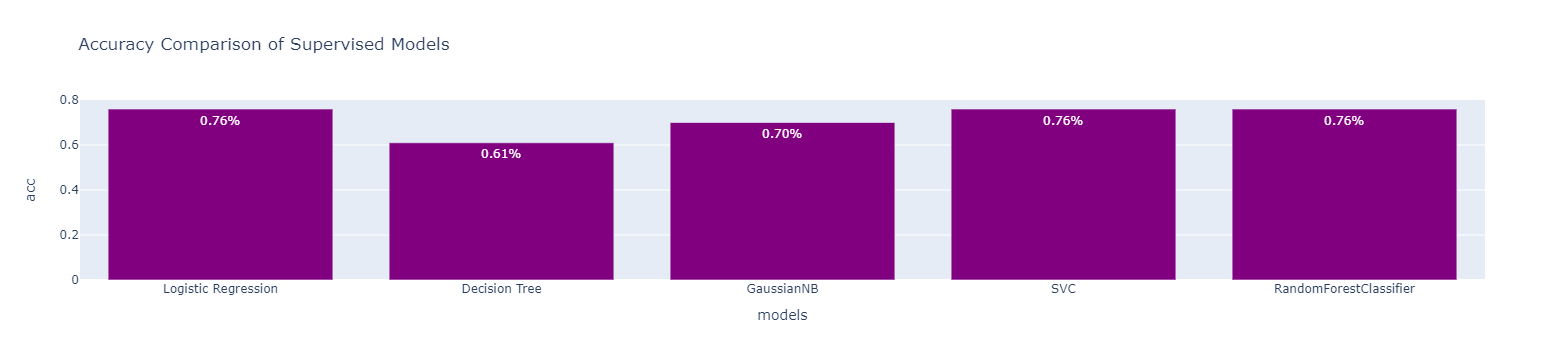

In [57]:
fig = px.bar(accdf, x='models', y='acc', text=accdf['acc'].apply(lambda x: '{0:1.2f}%'.format(x)), title = 'Accuracy Comparison of Supervised Models')
fig.update_traces(marker_color='purple')


### Task 10: Comparing Logistic Regression and SVC
By looking at the confusion matrix, we can state `Logistic Regression` as the base model for classification. 

### Task 11: Plotting Roc/ Precision Recall Curves

- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.

It is a probability curve that plopred_prob1 = model1.predict_proba(X_test)ts the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
def plot_roc_curve(model1,model2, y_test, y_pred):
    #calculating the predictive probability of different classes for our two models logistics and svc
    pred_prob1 = model1.predict_proba(X_test)
    pred_prob2 = model2.predict_proba(X_test)
    
    #print roc/auc score
    roc_auc_score_lr = roc_auc_score(y_test, pred_prob1, multi_class = 'ovr')
    roc_auc_score_svc = roc_auc_score(y_test, pred_prob2, multi_class = 'ovr')

    print(f'Logistic Regression Score:  {round(roc_auc_score_lr,2)}\n Support Vector Classifier: {round(roc_auc_score_svc,2)}')
    
    # roc curve for models
    fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
    fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    
    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label='SVC')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    plt.show()


In [ ]:
plot_roc_curve(lr_clf, svc, y_test, y_pred)

When <b>AUC = 1</b>, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly.

### Task 12: Predicting on New Data
Now, to make predictions, we'll need to add some preprocessing steps to convert a simple string into the correct format for our model to consume and make a prediction.

For this use use a function called predict_newdata. This function takes the string, tokenizes it using BertTokenizer and returns throse token tensors as a dictionary with 'input_ids' and 'attention_mask' 

In [217]:
topics={0 :'topic1', 
                 1 : 'topic2', 
                 2 : 'topic3'}

In [219]:
def predict_newdata(keyword,classifier):
    model_class, tokenizer_class, pretrained_weights = (tf.BertModel, tf.BertTokenizerFast, 'bert-base-uncased')

    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    
    #Tokenizing
    tokenized = tokenizer.batch_encode_plus(list(keyword),
                                        max_length = 5,
                                        pad_to_max_length=True,
                                        truncation=True)
    train_seq = torch.tensor(tokenized['input_ids'])
    train_mask = torch.tensor(tokenized['attention_mask']) 

    #Labels 
    label = df['Label']
    labels = torch.tensor(label.tolist())

    input_ids = torch.tensor(train_seq)  
    attention_mask = torch.tensor(train_mask)
    #print(input_ids)
    #print(attention_mask)

    #print(input_ids.shape)
    #print(attention_mask.shape)

    #Taking in the last CLS layer
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    features = last_hidden_states[0][:,0,:].numpy()

    topic = classifier.predict(features) 
    topic = np.argmax(topic)
    print(f'Keyword: {keyword} \nTopic: {topic}')
  
    return topic

In [ ]:
predict_newdata("best lenses for me", lr_clf)